# Adversarial Auto Encoder

<img src="https://miro.medium.com/max/2880/1*FK-_Qp8AeqrB2sHoD4iwIg.png"  width="600" height="300">

##### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from time import time
import re
import pandas as pd
import os
os.chdir('C:/Users/Nicolas/Documents/Data/Faces')
import argparse
import math
import itertools
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

##### Loading all file names

In [2]:
def load_women():
    faces = pd.read_csv('800_women.csv', header=None).values
    faces = faces.ravel().tolist()
    return faces
faces = load_women()
y = np.repeat(1, len(faces))

In [3]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### This is the shape width/height

In [4]:
dim = 60

##### Loading images

In [5]:
print('Scaling...', end='')
start = time()
x = []
prob = 0
num_to_load = len(faces)  
for ix, file in enumerate(faces[:8_000]): 
    image = plt.imread(file, 'jpg')
    if image.shape[0] != image.shape[1]:
        prob += 1
        print(prob)
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = np.array(image)
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')

Done. 0 seconds


##### Turning the pictures into arrays

In [6]:
x = np.array(x, dtype=np.float32).reshape(-1, 1, 60, 60)

##### Turning the targets into a 2D matrix

In [7]:
assert x.ndim == 4, 'The input is the wrong shape!'

In [8]:
print(x.shape)

(800, 1, 60, 60)


In [9]:
xx = x.nbytes

In [10]:
print(f'The size of x is {xx:,} bytes.')

The size of x is 11,520,000 bytes.


In [11]:
files, faces = None, None

##### Displaying the pictures

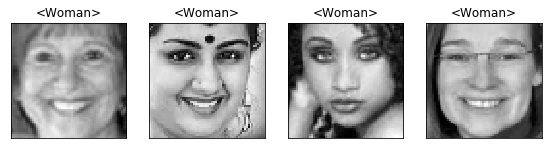

In [12]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(0, x.shape[0])
    ax = plt.imshow(x[rand][0, :, :], cmap='gray')
    plt.title('<Woman>')
    yticks = plt.xticks([])
    yticks = plt.yticks([])

In [13]:
print('Scaling...', end='')
image_size = x.shape[1] * x.shape[1] 
x = x.astype('float32') / 127.5 - 1 
print('\rDone.     ')

Done.     


In [14]:
if torch.cuda.is_available():
    x = torch.from_numpy(x) 
    y = torch.from_numpy(y)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Making a dataset class

In [15]:
class Face():
    
    def __init__(self):
        self.len = x.shape[0]
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return x[index], y[index].unsqueeze(0)
    
    def __len__(self):
        return self.len

##### Instantiating the class

In [16]:
train = Face()

##### Parsing the args

In [17]:
parser = argparse.ArgumentParser()

In [18]:
parser.add_argument("--n_epochs", type=int, default=100, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.005, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.3, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=3, help="dimensionality of the latent code")
parser.add_argument("--img_size", type=int, default=60, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=50, help="interval between image sampling")

_StoreAction(option_strings=['--sample_interval'], dest='sample_interval', nargs=None, const=None, default=50, type=<class 'int'>, choices=None, help='interval between image sampling', metavar=None)

In [19]:
# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()

In [20]:
print(opt)
img_shape = (opt.channels, opt.img_size, opt.img_size)

Namespace(b1=0.3, b2=0.999, batch_size=32, channels=1, img_size=60, latent_dim=3, lr=0.005, n_cpu=8, n_epochs=100, sample_interval=50)


##### Reparametrization

In [21]:
cuda = True if torch.cuda.is_available() else False

In [22]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), opt.latent_dim))))
    z = sampled_z * std + mu
    return z

##### Encoder

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, opt.latent_dim)
        self.logvar = nn.Linear(512, opt.latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z

##### Encoder

In [24]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img

##### Discriminator

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

##### Create loss function

In [26]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()

##### Instatiate the classes

In [27]:
# Initialize generator and discriminator
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

##### Send to cuda if possible

In [28]:
if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

##### Configure dataloader

In [29]:
# Configure data loader
dataloader = torch.utils.data.DataLoader(train, batch_size=opt.batch_size,
    shuffle=True,
)

##### Make pics

In [30]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def sample_image(n_row, batches_done, directory):
    """Saves a grid of generated digits"""
    # Sample noise
    z = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, "%s/%d.png" % (directory, batches_done), nrow=n_row, normalize=True)

##### Train the model

In [31]:
if not os.path.isdir('aae_800_women'):
            os.mkdir('aae_800_women')
        
for epoch in range(1, opt.n_epochs + 1):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
    batches_done = epoch * len(dataloader) + i

    if epoch >= 25 and epoch % 10 == 0:
        val = input("\nContinue training? [y/n]: ")
        print()
        if val in ('y', 'yes'):
            val = True
            pass
        elif val in ('n', 'no'):
            break  
        else:
            pass

    if epoch > 10:
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=5, batches_done=batches_done, directory='aae')

    if epoch % 5 == 0:
        print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, d_loss.item(), g_loss.item())
        )        

[Epoch 5/100] [D loss: 1.279353] [G loss: 0.369907]
[Epoch 10/100] [D loss: 0.667731] [G loss: 0.378677]
[Epoch 15/100] [D loss: 0.520293] [G loss: 0.359243]
[Epoch 20/100] [D loss: 0.194932] [G loss: 0.236719]
[Epoch 25/100] [D loss: 0.418368] [G loss: 0.244820]

Continue training? [y/n]: n



##### Generating 25,000 pictures

In [36]:
images = 0
for epoch in range(1, 2_000 + 1): # make it 200!
    for i, (imgs, _) in enumerate(dataloader):
        
        with torch.no_grad():

            # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            batches_done = epoch * len(dataloader) + i
            sample_image(directory='aae_800_women', n_row=5, batches_done=batches_done)
            images += 25
            
    if images % 5_000 == 0:
        print(f'Pictures created: {images:,}')
        
    if len(os.listdir(os.path.join(os.getcwd(), 'aae_800_women')))  >= 1_000:
        print('\n25,000 images successfully generated.')
        break

Pictures created: 5,000
Pictures created: 10,000
Pictures created: 15,000
Pictures created: 20,000
Pictures created: 25,000

25,000 images successfully generated.


##### Look at generated faces

In [ ]:
gen_faces = glob('aae/*.png')

In [ ]:
picture = plt.imread(r'C:\Users\Nicolas\Documents\Data\faces/aae/%s' \
                     % np.random.choice(gen_faces))
plt.figure(figsize=(6, 6))
plt.imshow(picture)
plt.xticks([]), plt.yticks([])
plt.title('Generated Faces')
plt.show()